In [2]:
import multiprocessing
from functools import reduce
import operator
import random

import numpy as np
import matplotlib.pyplot as plt
from neuron import h

%load_ext autoreload
%autoreload 2

from GrC import GrC
from Golgi import Golgi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Instantiation of the cell templates
golgi_cells = [[Golgi(i, morpho) for i in range(count)] for morpho, count in (
    (1, 3),  # 1 of morpho 1
    (2, 2),  # 1 of morpho 2
 )]

golgi_cells = reduce(operator.concat, golgi_cells)[:2]
random.shuffle(golgi_cells)
golgi_cells = golgi_cells[:2]

grc_cells = [[GrC(i, subtype) for i in range(count)] for subtype, count in (
    ("regular", 1), # 20%
    ("mild", 1), # 30%
    ("adapting", 1), # 40%
    ("accelerate", 1), # 10%
)]

grc_cells = reduce(operator.concat, grc_cells)
random.shuffle(grc_cells)
grc_cells = grc_cells[:4]

ascending_axons = sum((grc_cell.HD_aa for grc_cell in grc_cells), [])

paralell_fibers = sum((grc_cell.HD_pf for grc_cell in grc_cells), [])



5394 lines read

5394 lines read

5394 lines read

5456 lines read

morphology/pair-140514-C2-1_split_2.asc problems


Main branch starting at line 58 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 2375 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

5456 lines read

morphology/pair-140514-C2-1_split_2.asc problems


Main branch starting at line 58 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 2375 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

103 lines read

103 lines read

103 lines read

103 lines read


In [4]:
# Fixed time step only
time_step = h.CVode()
time_step.active(0)  # 0 fixed step, 1 variable time step

# Activate the multisplit to use half of cores available (with a max of 8)
cpu = multiprocessing.cpu_count() // 2
h.load_file("parcom.hoc")
p = h.ParallelComputeTool()
p.change_nthread(min(8, cpu), 1)
p.multisplit(1)

0.0

In [5]:
# Number of spikes, interval, starting moment, delay factor to activate two different types of synapses in two different moments, presence of noise
# See the defaults in create_syn_stims()
synapse_data_pf = {'number': 5, 'interval': 10, 'start': 100}
synapse_data_mf = {'number': 5, 'interval': 10, 'start': 100}
synapse_data_aa = {'number': 5, 'interval': 10, 'start': 100}

# time to stop the entire simulation (ms)
h.tstop = 1000  

stims = []
ncs = []

def create_syn_stim_bursts(synapses, number=5, interval=10, start=100, delay=0, noise=0):
    """
    Generates burst inputs that are connected onto the given synapses.

    Number is the total number of spikes in the burst.
    Interval is the number of ms between spikes in a burst.
    Start is the time between bursts (from the start of one burst to the start of the next burst).
        The first burst is at start time as well.
    Delay changes when the burst occurs (negative will move it relatively sooner, positive will be later)
    Noise is a number from 0 to 1 for amount of randomness within a single burst
    """
    
    if number * interval > start:
        print("Warning: you are going to have overlapping bursts")

    totalstim = int(h.tstop / start)
    for j in range(totalstim):
        s = h.NetStim()
        s.interval = interval
        s.number = number
        s.noise = noise
        s.start = start * (totalstim - j) + delay
        stims.append(s)
        ncs.extend(h.NetCon(s, syn.input, 0, 0.1, 1) for syn in synapses)
    #return stims, ncs

for j, grc_cell in enumerate(grc_cells):
    # number of AMPA syn, NMDA syn, dend number from 0 to 3
    grc_cell.createsyn(1, 1, [0, 1], [0, 1])
    create_syn_stim_bursts(grc_cell.MF_GrC_AMPA + grc_cell.MF_GrC_NMDA_B, **synapse_data_mf)

for j, golgi_cell in enumerate(golgi_cells):

    # number of AMPA syn, NMDA syn, dend number from 0 to 3

    # Create the synapses (max used in the paper: 89, 20, 20)
    # Not included: inhibitory synapses (up to 20 in the paper)

    # 1 Parallel Fiber reaches 8 Golgi cells, each one synapses ~3 times onto a Golgi cell, 400 Parallel Fibers connect to a single Golgi cell

    # 1 Ascending Axon reaches 23 Golgi cells, each one synapses ~1 times onto a Golgi cell. About 400 ascending axons to a golgi cell

    # 1 golgi cell reaches 40 mossy fibers, each one synapses ~1 time onto a golgi cell, one golgi cell recieves input 
    # from 40 different mossy fibers

    golgi_cell.createsyn(mf_n=0,
                         pf_n=len(grc_cells)*3,
                         aa_n=len(ascending_axons)*((len(ascending_axons) // 4))) 
    
    # Mossy Fiber Connection
    grc_cell.createsyn(1, 1, [0, 1], [0, 1]) # number of AMPA syn, NMDA syn, dend number from 0 to 3
    create_syn_stim_bursts(grc_cell.MF_GrC_AMPA + grc_cell.MF_GrC_NMDA_B, **synapse_data_mf)

    # Parallel Fiber Connections
    for i, grc_cell in enumerate(grc_cells):
        pf_i = random.randrange(0, len(grc_cell.HD_pf))
        pf = grc_cell.HD_pf[pf_i]
        sections = [pf[random.randrange(len(pf))] for _ in golgi_cell.L_PF] # was this made or is this L_PF somewhere?
        ncs.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_PF, sections))

    # Ascending Axons Connections
    for i, grc_cell in enumerate(grc_cells):
        n = len(grc_cell.HD_aa)
        locations = np.random.normal(n/2, 2, len(golgi_cell.L_AA)).round().astype(int).clip(0, n-1)
        sections = [grc_cell.HD_aa[loc] for loc in locations]
        ncs.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_AA, sections))


In [6]:
# Basic properties of the simulation
h.dt = 0.025    # change in time between steps (ms)
h.celsius = 32  # temperature of the neurons (*C)
h.v_init = -65  # initial membrane potential (mV)

time = h.Vector()
time.record(h._ref_t)
h.finitialize()
h.run()

0.0

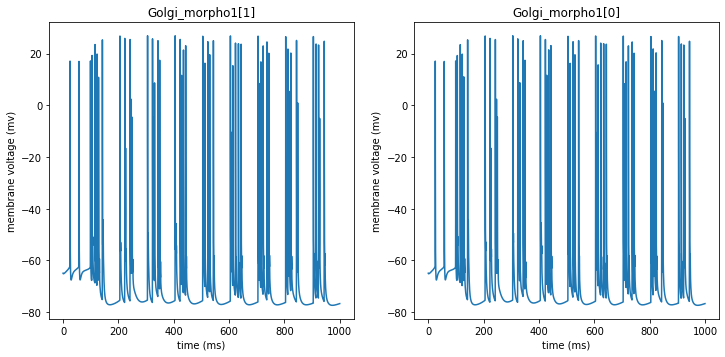

In [7]:
plt.figure(figsize=(12, 12))
for j, golgi_cell in enumerate(golgi_cells):
    plt.subplot(len(golgi_cells), 2, j + 1)
    plt.plot(time, np.array(golgi_cell.vm), label=str(golgi_cell))
    time = np.array(time)
    plt.title(f"{golgi_cell}")
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")

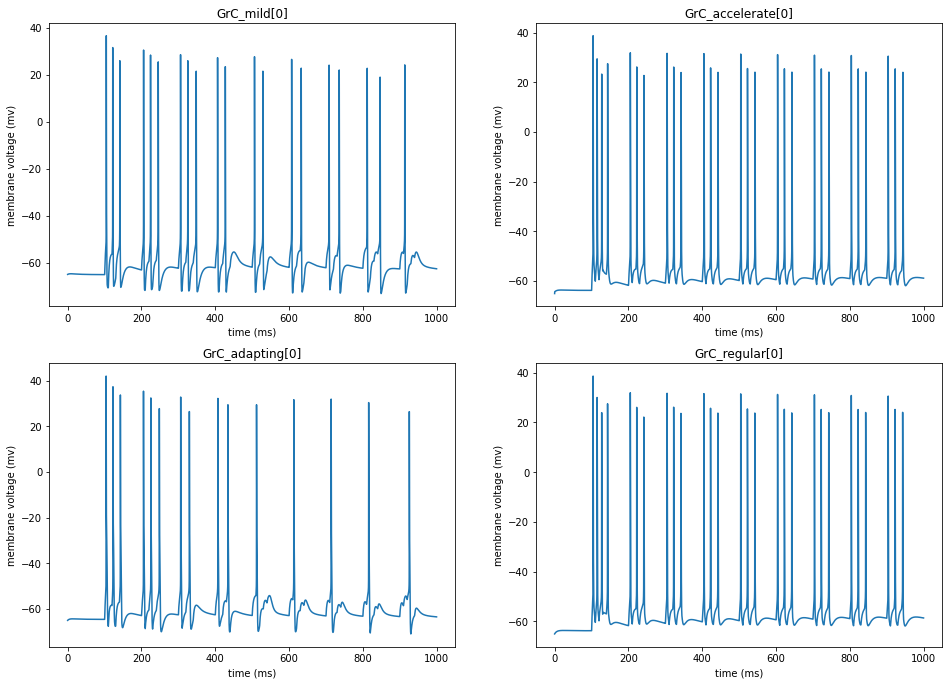

In [8]:
plt.figure(figsize=(16, 24))
for j, grc_cell in enumerate(grc_cells):
    plt.subplot(len(grc_cells), 2, j + 1)
    plt.plot(time, np.array(grc_cell.vm_soma), label=str(grc_cell))
    time = np.array(time)
    plt.title(f"{grc_cell}")
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")